# NFL COMBINE PLAYER DATA ANALYSIS
Michael Wayne and Ibrahim Taher

The NFL combine is the one of the first times after a player declares themselves for the draft that they showcase their athletic ability. The combine, much like the rest of the NFL is a statistics goldmine. Everything from their declared position to their bench press is taken into consideration for how they will play out as an athlete. Our project is to see how combine affects these player's future in the NFL or if they even have one. Will they get drafted, and can we use this data to see how their careers pan out? We'll find out! 

In [5]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline
import os
import requests
from bs4 import BeautifulSoup as BS
import time
from pprint import pprint
import statsmodels.api as sm
import sklearn.utils as utils
import sklearn.cross_validation as cross_validation

C:\Users\Owner\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


**Check with Wayne if scrape_nfl.ipynb is what to put in this cell or NFL_SCRAPE.ipynb is what to put here!**

**Part I: Scraping the Data**
In order to acquire our data, we found that full-fledged datasets were owned by the NFL or websites that were only willing to give the dataset in its completion if we paid for them. Therefore, using BeautifulSoup4, we scraped our data from several websites.

*Part I.i Scraping Combine Results*
The first part of our dataset was the combine results. Luckily, we found a website called nflcombineresults.com that had all the data on their website of combine results from 1999 to 2015 for several combine events. They also had players' physical attributes at the time. We eventually removed data so that it ended up only being 2004 to 2013 in the dataset.

In [ ]:
headers = ["Year", "Name", "College", "POS", "Height", "Weight", "Hand Size", "Arm Length", "Wonderlic", "Yard", 
           "Bench Press", "Vert Leap", "Broad Jump", "Shuttle", "3 Cone", "60Yd Shuttle"]
data_out = []

url = "http://nflcombineresults.com/nflcombinedata_expanded.php?year=all&pos=&college="

response = requests.get(url)
html = response.text.encode('utf-8').__str__()
n = html.find("<head")

pos_soup = BS(html[n:], "html.parser")
    
tr_list = pos_soup.find_all('tr')

for tr in tr_list:
    try:
        if 'tablefont' in tr['class'][0]:
            count = 0
            player_res = []
            td_list = tr.find_all('td')
            for td in td_list:
                if count == 1:
                    player_res.append(td.div.a.contents[0])
                    count += 1
                else:
                    if len(td.div.contents) > 0:
                        player_res.append(td.div.contents[0])
                        count += 1
                    else:
                        player_res.append('')
                        count += 1
            data_out.append(player_res)
    except KeyError:
        pass
        
data_str = ''
for header in headers:
    data_str += header + ','
data_str += '\n'

for data in data_out:
    for d in data:
        data_str += d + ','
    data_str += '\n'
    
out = open('combine_output.csv', 'w')
out.write(data_str)
out.close()
print('Done')

*Part I.ii: Scraping Games Started*
To create our first observation vector for our eventual OLS, we scraped information on games started. For each player we scraped information on how many games started over their entire career, the amount of games they started in their first three years and the amount of games they played in general. We scraped the latter two just to see if they would have any sort of effect on our data and see if they were better fitted by our linear model.

In [ ]:
def check_tag(tag, subtag, check):
    try:
        if check in tag[subtag]:
            return True
        return False
    except KeyError:
        return False
    
pos_trans = {'ILB': ['ILB','LB'],
            'OLB': ['OLB','LB'],
            'FS': ['S','DB'],
            'SS': ['S','DB'],
            'OT': ['OT', 'OL', 'T'],
            'OG': ['OG', 'OL','G'],
            'C': ['C', 'OL'],
            'QB': ['QB'],
            'RB': ['RB'],
            'WR': ['WR'],
            'TE': ['TE'],
            'CB': ['CB', 'DB'],
            'DE': ['DE'],
            'DT': ['DT'],
            'FB': ['FB']}

In [ ]:
CDo = open('COMBINE_DATA.csv')
full = [cd.split(',') for cd in CDo.read().split('\n')]
headers = full[0]
CD = full[1:-1]

base_url = "http://www.pro-football-reference.com/search/search.fcgi?hint=%s+%s&search=%s+%s&pid="
pf_url = "http://www.pro-football-reference.com"
url_dict = {}

final_str = ''
for header in headers:
    final_str += header + ','
final_str += 'G,GS,G3,GS3\n'

for player in range(326, len(CD)):
    if player % 100 == 0:
        print('\n%s / 3124\n' % str(player))
    name = CD[player][1].replace('\\','')
    CD[player][1] = name
    ns = name.split(' ')
    if len(ns) != 2:
        ns = [ns[0], '%s+%s' % (ns[1],ns[2])]
        
    player_url = base_url % (ns[0], ns[1], ns[0], ns[1])
    response = requests.get(player_url)
    html = response.text.encode('utf-8').__str__()
    n = html.find("<html")
    player_soup = BS(html[n:], "html.parser")
    title_list = player_soup.find_all('title')
    
    player_page = 1
    if 'Search Results' in title_list[0].contents[0]:
        player_page = 0
        
    if not player_page:
        div_list = player_soup.find_all('div')
        for div in div_list:
            if check_tag(div, 'id', 'players'):
                div_list2 = div.find_all('div')
                if div_list2:
                    for div2 in div_list2:
                        try:
                            pos = div2.div.contents[2].split(' ')[2]
                            year = div2.div.contents[2].split(' ')[3][1:5]
                            if pos in pos_trans[CD[player][3]]:
                                if year == CD[player][0]:
                                    player_url = pf_url + div2.div.a['href']
                                    response = requests.get(player_url)
                                    html = response.text.encode('utf-8').__str__()
                                    n = html.find("<html")
                                    player_soup = BS(html[n:], "html.parser")
                                    title_list = player_soup.find_all('title')
                                    break
                        except AttributeError:
                            pass
                    break
    
    resl = [0,0,0,0,0]
    
    if 'Search Results' not in title_list[0].contents[0]:
        table_list = player_soup.find_all('table')
        for table in table_list:
            if check_tag(table, 'class', 'row_summable') and check_tag(table, 'class', 'sortable') and not check_tag(table, 'id', 'passing_clone'):
                th_list = table.thead.find_all('th')
                year = False
                for th in th_list:
                    if check_tag(th, 'aria-label', 'Year'):
                        year = True
                        break
                if year:
                    tr_list = table.tbody.find_all('tr')
                    for tr in tr_list:
                        td_list = tr.find_all('td')
                        if len(tr.th.contents) > 0:
                            try:
                                if tr.th.a.contents[0] == '2016':
                                    resl[4] += (11/16)
                                else:
                                    resl[4] += 1
                            except AttributeError:
                                if tr.th.contents[0] == '2016':
                                    resl[4] += (11/16)
                                else:
                                    resl[4] += 1
                            for td in td_list:
                                if check_tag(td, 'data-stat', 'gs'):
                                    if len(td.contents) > 0:
                                        gs = int(td.contents[0])
                                        resl[1] += gs
                                        if resl[4] > 3:
                                            resl[3] += gs
                                elif td['data-stat'] == 'g':
                                    if len(td.contents) > 0:
                                        g = int(td.contents[0])
                                        resl[0] += g
                                        if resl[4] > 3:
                                            resl[2] += g
    
    res0, res1, res2, res3 = 0, 0, 0, 0
    if resl[4] > 0:
        res0 = resl[0]/resl[4]
        res1 = resl[1]/resl[4]
        if resl[4] > 3:
            res2 = resl[2]/(resl[4] - 3)
            res3 = resl[3]/(resl[4] - 3)
    print(name, res0, res1, res2, res3, resl[4])
    CD[player].append(str(res0))
    CD[player].append(str(res1))
    CD[player].append(str(res2))
    CD[player].append(str(res3))
    for p in CD[player]:
        final_str += p + ','
    final_str += '\n'

print('DONE')

*Part I.iii: Draft Position Scraping*

In [ ]:
def check_tag(tag, subtag, check):
    try:
        if check in tag[subtag]:
            return True
        return False
    except KeyError:
        return False
    
pos_trans = {'ILB': ['ILB','LB'],
            'OLB': ['OLB','LB'],
            'FS': ['S','DB'],
            'SS': ['S','DB'],
            'OT': ['OT', 'OL', 'T'],
            'OG': ['OG', 'OL','G'],
            'C': ['C', 'OL'],
            'QB': ['QB'],
            'RB': ['RB'],
            'WR': ['WR'],
            'TE': ['TE'],
            'CB': ['CB', 'DB'],
            'DE': ['DE'],
            'DT': ['DT'],
            'FB': ['FB']}

base_url = "http://www.pro-football-reference.com/years/%s/draft.htm"

player_list = []

for y in range(2004, 2014):
    d_count = 1
    year = str(y)
    year_url = base_url % year
    response = requests.get(year_url)
    html = response.text.encode('utf-8').__str__()
    n = html.find("<html")
    year_soup = BS(html[n:], "html.parser")
    table_list = year_soup.find_all('table')
    for table in table_list:
        if check_tag(table, 'class', 'sortable'):
            tb = table.tbody
            trs = tb.find_all('tr')
            for tr in trs:
                if not check_tag(tr, 'class', 'thead'):
                    tds = tr.find_all('td')
                    player = []
                    for td in tds:
                        if check_tag(td, 'data-stat', 'player'):
                            player.append(257 - d_count)
                            d_count += 1
                            try:
                                player.append(td.strong.a.contents[0])
                            except AttributeError:
                                try:
                                    player.append(td.a.contents[0])
                                except AttributeError:
                                    player.append(td.contents[0])
                        elif check_tag(td, 'data-stat', 'pos'):
                            pos = td.contents[0]
                            pl = []
                            for p in pos_trans:
                                if pos in pos_trans[p]:
                                    pl.append(p)
                            player.append(pl)
                            player.append(y)
                            player_list.append(player)
                            break
                            
out2 = open('OUTPUT2.csv').read().split('\n')

final_str = out2[0] + ',DRAFT,\n'

for o in out2[1:-1]:
    os = o.split(',')
    drafted = False
    for p in player_list:
        if os[1] == p[1] and int(os[0]) == p[3] and os[3] in p[2]:
            new_list = os + [str(p[0])]
            for i in new_list:
                final_str += i + ','
            final_str += '\n'
            drafted = True
    if not drafted:
        new_list = os + ['0']
        for i in new_list:
            final_str += i + ','
        final_str += '\n'
            
outd = open('OUTPUT_DRAFT.csv','w')
outd.write(final_str)
outd.close()
print('Done')


*Part I.iv: Scraped College Rankings*
Another predictor we decided to use was a player's alma mater's ranking at the time of him being drafted. We felt that this was important because better schools have more competitive athletes, and we can assume that better schools output better players. We wanted to see if the data provided the same evidence by showing whether school ranking in the NCAA was a significant predictor.

In [ ]:
import os
import requests
from bs4 import BeautifulSoup as BS
from pprint import pprint

def check_tag(tag, subtag, check):
    try:
        if check in tag[subtag]:
            return True
        return False
    except KeyError:
        return False
        
ap_poll = {}
total_schools = {}
school_appear = {}
school_trans = {'Brigham Young': 'BYU',
                'Southern Cal': 'Southern California',
                'Southern Miss': 'Southern Mississippi',
                'Miami-Florida': 'Miami',
                'Nebraksa': 'Nebraska',
                'Texas A&M': 'Texas A&M;',
                'Louisiana St.': 'LSU',
                'Miami-Ohio': 'Miami (OH)'}

base_url = "http://preseason.stassen.com/final-ap-poll/%s.html"

for y in range(2003, 2013):
    comb_year = y+1
    ap_poll[comb_year] = []
    year = str(y)
    year_url = base_url % year
    response = requests.get(year_url)
    html = response.text.encode('utf-8').__str__()
    n = html.find("<html")
    year_soup = BS(html[n:], "html.parser")
    table_list = year_soup.find_all('table')
    for table in table_list:
        trs = table.find_all('tr')
        for tr in trs:
            if check_tag(tr, 'align', 'CENTER'):
                team = tr.contents[3].contents[0]
                if '(' in team:
                    start = team.find('(')
                    team = team[:start - 1]
                    if team in school_trans:
                        team = school_trans[team]
                if team != 'Team':
                    if team in school_trans:
                        team = school_trans[team]
                    if team not in total_schools:
                        total_schools[team] = 0
                    if team not in school_appear:
                        school_appear[team] = 0
                    school_appear[team] += 10
                    rank = tr.contents[1].contents[0]
                    points = tr.contents[7].contents[0].replace(',','')
                    ap_poll[comb_year].append([team, rank, points])

outd = open('OUTPUT_DRAFT.csv').read().split('\n')

point = outd[0].find('POS')
final_str = outd[0][:point] + 'AP Poll Points,' + outd[0][point:] + '\n'

for o in outd[1:-1]:
    os = o.split(',')
    school = os[2]
    year = int(os[0])
    ap_year = ap_poll[year]
    found = False
    for s in range(len(ap_year)):
        ss = ap_year[s]
        if school == ss[0]:
            found = True
            points = str(int(ss[2]) / 100)
            total_schools[ss[0]] += 1
    if not found:
        try:
            points = str(school_appear[school] / 100)
        except KeyError:
            points = '0'
    new_list = os[:3] + [points] + os[3:]
    for i in new_list:
        final_str += i + ','
    final_str += '\n'

outdp = open('OUTPUT_DRAFT2.csv','w')
outdp.write(final_str)
outdp.close()

print('Done')

*Part I.v: Combining Scraped Data*

We now decided it was appropriate the combine the data about the combine resutls with the game started.

In [ ]:
from pprint import pprint

comb = open('COMBINE_DATA.csv').read().split('\n')
out = open('OUTPUT.csv').read().split('\n')

comb_data = {}

for c in comb[1:-1]:
    cs = c.split(',')
    key = (cs[0],cs[1],cs[2],cs[3])
    try:
        comb_data[key] = [cs[i] for i in range(4,14)]
    except IndexError:
        print(cs)
    
final_str = out[0] + '\n'

for o in out[1:-1]:
    os = o.split(',')
    nums = [0,1,2,3,14,15,16,17]
    os_nums = [os[num] for num in nums]
    key = (os[0],os[1],os[2],os[3])
    for comb_key in comb_data:
        if key == comb_key:
            res = os_nums[:4] + comb_data[comb_key] + os_nums[4:]
            for r in res:
                final_str += r + ','
            final_str += '\n'

out2 = open('OUTPUT2.csv','w')
out2.write(final_str)
out2.close()
print('Done')
    
pprint(comb_data)

In [ ]:
out3 = open('OUTPUT2.csv').read().split('\n')

poss = ['DT','QB','OG','C','WR','RB','FB','CB','FS','TE','DE','SS','OLB','ILB','OT']
years = [str(year) for year in range(2004, 2014)]

for o in out3:
    os = o.split('\n')

In [ ]:
out = open('OUTPUT2.csv').read().split('\n')

headers = out[0].split(',')
poss = ['DT','QB','OG','C','WR','RB','FB','CB','FS','TE','DE','SS','OLB','ILB','OT']
    
out_D = {header: [] for header in headers}

usable1 = ['Height', 'Weight', 'Yard', 'Bench Press', 'Vert Leap', 'Broad Jump', 'Shuttle', '3 Cone']

for o in out[1:-1]:
    o = o.split(',')
    for i in range(len(o)):
        if headers[i] in usable1:
            try:
                f = float(o[i])
            except ValueError:
                o[i] = np.nan
        out_D[headers[i]].append(o[i])
        
P = pd.DataFrame(out_D)

P

**Part II: Creating our Full DataFrame**

*Part II.i: Obtaining the Means**

Although a small, yet significant part, we noticed that a lot of the combine predictors were missing values. Therefore, instead of keeping a NaN in the dataframe, we decided to replace each NaN with that position's mean at that event during the year that a player participated in the combine. 

In [4]:
combine_df1=pd.read_csv('OUTPUT_DRAFT.csv')
for i in range(len(combine_df1['Yard'])):
    yard=float(str(combine_df1['Yard'].iloc[i]).replace('*',''))
    combine_df1['Yard'].iloc[i]=yard
combine_df1['Yard']=pd.to_numeric(combine_df1['Yard'], errors='coerce')
combine_df1=combine_df1.drop(['Hand Size','Arm Length','Unnamed: 19','Name','College'],axis=1)
combine_df1=combine_df1.groupby(['Year','POS']).mean()
combine_df1.to_csv('year-pos-mean-combine.csv')
combine_df1

C:\Users\Owner\Anaconda3\lib\site-packages\pandas\core\indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Height      Weight      Yard  Bench Press  Vert Leap  Broad Jump  \
Year POS                                                                        
2004 C    75.500000  302.000000  5.297500    24.200000  27.928571   96.750000   
     CB   71.818182  193.636364  4.471818    13.888889  35.909091  120.363636   
     DE   76.000000  263.352941  4.769412    23.250000  33.147059  115.529412   
     DT   75.764706  311.411765  5.102353    27.733333  28.500000  104.294118   
     FB   73.333333  240.333333  4.700000    25.500000  32.166667  117.000000   
     FS   72.500000  203.666667  4.548333    16.600000  36.833333  118.000000   
     ILB  74.800000  239.400000  4.700000    26.750000  34.500000  115.500000   
     OG   76.538462  314.307692  5.405385    23.666667  27.692308  100.846154   
     OLB  73.583333  233.166667  4.654167    23.444444  34.333333  116.500000   
     OT   78.111111  318.277778  5.266111    25.200000  28.611111  102.611111   
     QB   76.000000  229.666667  4.890000          NaN  30.055556  112.000000   
     RB   71.375000  211.750000  4.581250    20.250000  34.000000  116.625000   
     SS   71.333333  209.000000  4.520000    16.000000  37.666667  122.666667   
     TE   76.583333  266.750000  4.937500    20.166667  30.875000  111.250000   
     WR   73.000000  201.789474  4.553684          NaN  35.000000  120.526316   
2005 C    75.875000  307.000000  5.212857    25.428571  31.437500  104.125000   
     CB   71.380952  191.190476  4.440476    14.210526  38.952381  123.523810   
     DE   75.684211  268.947368  4.834737    22.666667  34.052632  113.894737   
     DT   75.176471  305.823529  5.091250    26.214286  30.441176  106.312500   
     FB   73.800000  248.400000  4.860000    23.400000  30.400000  107.800000   
     FS   73.333333  210.444444  4.560000    17.142857  38.111111  120.111111   
     ILB  73.750000  242.250000  4.735833    25.181818  33.875000  115.100000   
     OG   76.600000  316.200000  5.261333    26.000000  30.000000  102.066667   
     OLB  74.428571  239.500000  4.637857    22.916667  37.642857  119.769231   
     OT   78.047619  316.380952  5.357619    23.187500  29.357143  100.047619   
     QB   74.944444  220.333333  4.816667    22.000000  30.833333  110.333333   
     RB   71.000000  219.300000  4.532500    19.333333  34.600000  116.157895   
     SS   71.750000  217.250000  4.638750    19.000000  34.250000  116.666667   
     TE   76.250000  258.500000  4.735000    21.000000  34.250000  114.875000   
     WR   73.052632  198.631579  4.525263    20.000000  36.947368  119.526316   
...             ...         ...       ...          ...        ...         ...   
2012 C    74.600000  307.000000  5.280000    26.200000  27.500000   98.400000   
     CB   70.916667  193.500000  4.501250    16.100000  34.416667  119.625000   
     DE   75.809524  270.380952  4.800952    25.933333  32.595238  113.142857   
     DT   75.190476  302.571429  5.029524    30.000000  30.238095  105.857143   
     FB   73.500000  242.000000  4.647500    18.000000  35.625000  119.250000   
     FS   73.750000  206.000000  4.535000    16.500000  35.500000  125.500000   
     ILB  74.166667  241.833333  4.678333    21.500000  34.000000  116.500000   
     OG   75.937500  315.437500  5.282500    26.071429  27.781250  100.600000   
     OLB  73.736842  244.000000  4.662632    23.526316  33.916667  116.722222   
     OT   77.571429  315.714286  5.214286    24.700000  27.761905  101.000000   
     QB   74.750000  216.833333  4.725000    14.000000  32.583333  111.333333   
     RB   69.947368  211.473684  4.490000    21.066667  35.289474  117.736842   
     SS   72.500000  208.928571  4.555000    18.583333  34.642857  121.071429   
     TE   76.000000  249.428571  4.684286    20.000000  33.285714  118.142857   
     WR   72.962963  204.296296  4.472222    15.680000  35.907407  120.730769   
2013 C    75.500000  308.500000  5.310000    27.200000  25.833333   98.166667   
     CB   71.192308  192.153846  4.503462   

*Part I.ii: Creating the DataFrame*

Here we put everything together. We took our newly created csv and made a DataFrame out of it. For any player, when a NaN was found for an event, we replaced it with the mean of said event for said position in said year. 

In [3]:
from pprint import pprint

out = open('OUTPUT_DRAFT2.csv').read().split('\n')

yards = {year: {} for year in range(2004, 2014)}

for o in out[1:-1]:
    os = o.split(',')
    if os[9]:
        y = float(os[9].replace('*',''))
        yr = int(os[0])
        pos = os[4]
        if pos not in yards[yr]:
            yards[yr][pos] = []
        yards[yr][pos].append(y)

headers = out[0].split(',')
poss = ['DT','QB','OG','C','WR','RB','FB','CB','FS','TE','DE','SS','OLB','ILB','OT']

yards_avg = {year: {pos: sum(yards[year][pos])/len(yards[year][pos]) for pos in poss} for year in range(2004,2014)}

uQB = ['AP Poll Points', 'Height', 'Weight', 'Yard', 'Vert Leap', 'Broad Jump', 'Shuttle', '3 Cone']
usable1 = uQB + ['Bench Press']

avgs_P = pd.read_csv('year-pos-mean-combine.csv')

out_D2 = {header: [] for header in headers}

for o in out[1:-1]:
    o = o.split(',')
    for i in range(len(headers)):
        if headers[i] in usable1:
            try:
                oi = o[i].replace('*','')
                f = float(oi)
            except ValueError:
                year = o[0]
                pos = o[4]
                if headers[i] != 'Yard':
                    for index, row in avgs_P.iterrows():
                        if row['Year'] == int(year) and row['POS'] == pos:
                            o[i] = row[headers[i]]
                else:
                    o[i] = yards_avg[int(year)][pos]
        out_D2[headers[i]].append(o[i])
        
P2 = pd.DataFrame(out_D2)

P2

,3 Cone,AP Poll Points,Arm Length,Bench Press,Broad Jump,College,DRAFT,G,G3,GS,GS3,Hand Size,Height,Name,POS,Shuttle,Vert Leap,Weight,Yard,Year
0,7.81,0.1,,27,114,Kansas,125,11,9,5.2,5,,76,Adrian Jones,OT,4.6,31,296,4.97,2004
1,7.93,14.11,,23.6667,102,Ohio State,30,14,0,9,0,,77,Adrien Clarke,OG,4.79,26,329,5.52,2004
2,8.75,0.6,,27.7333,86,Alabama,0,0,0,0,0,,78,Ahmad Childress,DT,4.94,22,351,5.28,2004
3,7.96,0.2,,26,98,Texas A&M;,0,0,0,0,0,,78,Alan Reuber,OG,5,29,314,5.49,2004
4,7.06,0.7,,25,121,Wisconsin,117,10.4,12.5,1.8,2.5,,73,Alex Lewis,OLB,4.31,34.5,228,4.78,2004
5,7.64,14.11,,24.2,96,Ohio State,157,9.2,8,6.8,2,,76,Alex Stepanovich,C,4.54,25.5,304,5.29,2004
6,7.32,0,,NaN,121,Southern Oregon,0,8.5,0,0.5,0,,71,Andrae Thurman,WR,4.33,34.5,192,4.54,2004
7,7.46,8.33,,16,107,Kansas State,0,0,0,0,0,,77,Andrew Shull,DE,4.28,30.5,265,4.9,2004
8,8.15,0,,27,101,Kentucky,0,0,0,0,0,,76,Antonio Hall,OG,4.56,26.5,317,5.54,2004
9,7.31188,0.3,,24,108,Oklahoma State,122,14.1871921182,15.4838709677,10.4827586207,12.0774193548,,76,Antonio Smith,DE,4.75,33,274,5.03,2004


**Part III: Ordinary Least Squares Model For Draft Position**

*Part III.i: Creating the OLS model for Draft Position*

We used our combine data as our Design Matrix and the Draft Position as our observation vector. We split the data into training and testing, with our training data being 60% of our entire dataset. We also created an OLS for each position because we felt that this increased the fit of our model. We ran the model then on the test set for each position and obtain the errors for each position.

In [7]:
all_predictions_D=[]
all_results_D=[]
for pos in poss:
    print('\n\n\n--------------' + pos + '---------------')
    P_pos = P2.loc[P2['POS'] == pos]
    
    if pos == 'QB':
        X_P_H = P_pos[uQB]
    else:
        X_P_H = P_pos[usable1]
    print('Complete dataset shape is {}'.format(X_P_H.shape))
    y_P_H = P_pos.DRAFT;

    X_P_H, y_P_H = utils.shuffle(X_P_H, y_P_H, random_state=1)
    X_P_H_train, X_P_H_test, y_P_H_train, y_P_H_test = cross_validation.train_test_split(
        X_P_H, y_P_H, test_size=0.4, random_state=0)

    subX_train = X_P_H_train[X_P_H_train.columns[0]]
    subX_test = X_P_H_test[X_P_H_test.columns[0]]
    
    model = sm.OLS(y_P_H_train.astype(float), X_P_H_train.astype(float), missing='drop')
    results = model.fit()
    predictions = results.predict(X_P_H_test.astype(float))
    all_predictions_D.append(predictions)
    all_results_D.append([float(x) for x in list(y_P_H_test)])
    print(results.summary())

D_errors=[]
for i in range(len(all_predictions_D)):
    pos_error= []
    for j in range(len(all_predictions_D[i])):
        pos_error.append(all_predictions_D[i][j] - all_results_D[i][j])
    D_errors.append(pos_error)




--------------DT---------------
Complete dataset shape is (156, 9)
                            OLS Regression Results                            
Dep. Variable:                  DRAFT   R-squared:                       0.607
Model:                            OLS   Adj. R-squared:                  0.565
Method:                 Least Squares   F-statistic:                     14.43
Date:                Wed, 14 Dec 2016   Prob (F-statistic):           8.14e-14
Time:                        03:28:42   Log-Likelihood:                -541.09
No. Observations:                  93   AIC:                             1100.
Df Residuals:                      84   BIC:                             1123.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------

In [8]:
for i in range(len(poss)):
    print(poss[i],' errors in terms predicted draft values and actual drafted values are',D_errors[i])

DT  errors in terms predicted draft values and actual drafted values are [-139.05446328685787, -94.769030142019389, -100.39113489433606, -134.46244733752508, -89.159053592998873, -123.12616013915226, 56.871772088430561, -128.6130116191124, 63.457054941288845, 96.615089725528819, 16.69341402711521, 69.370253265863496, 50.234778784377326, -59.909633950041751, -82.777118969488768, 61.533184742434884, 103.36555167770156, -6.3577119817780954, -95.127453503016227, 40.525034768081483, 11.656882486555247, -18.302919445683358, 131.0276774244343, 64.342056463365822, 44.317426858979971, -15.439298706103003, -83.429086045171942, 13.900399230204201, -37.338785785394478, -19.752387095888338, 61.598324351900288, 69.166357427740593, -90.622080122680956, -29.470185386898549, -43.129553403663834, 116.3381198066589, -76.992101707425604, -147.3481663102516, -30.861503942898295, -47.418807983913965, 49.418389503210349, 19.725602273282249, 66.865677942635955, 7.2558559494611785, -72.538934617559619, 63.4128

*Part III.ii: Histogram of Errors*

We plotted the errors of draft position of the test set to actual results on a histogram with our range being -256 to 256. The further from 0 the value was meant the more we either overestimated or underestimated the draft position.

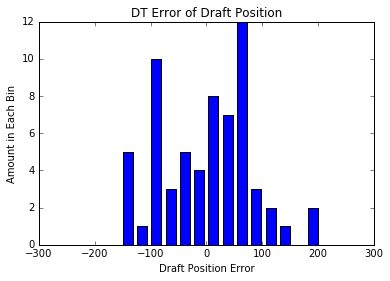

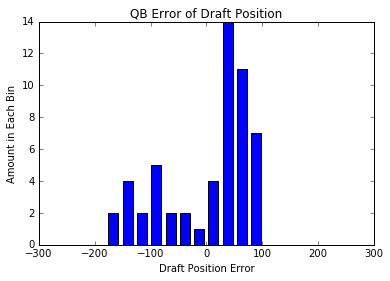

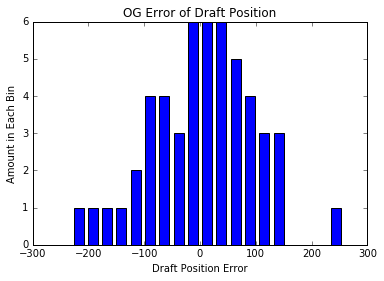

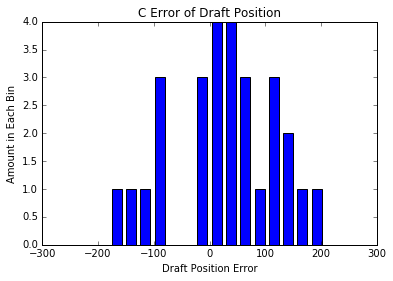

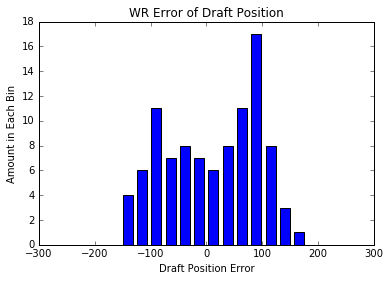

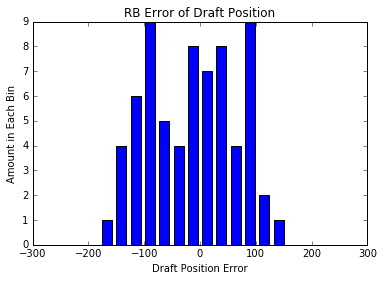

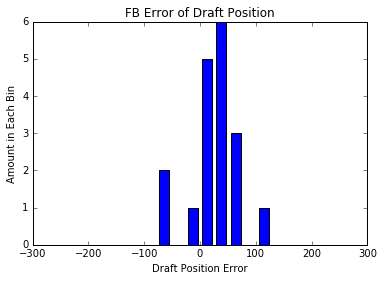

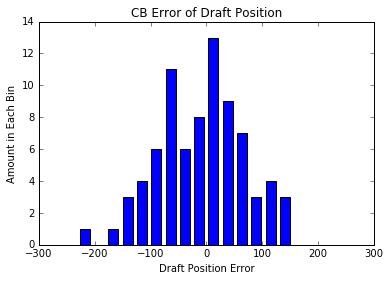

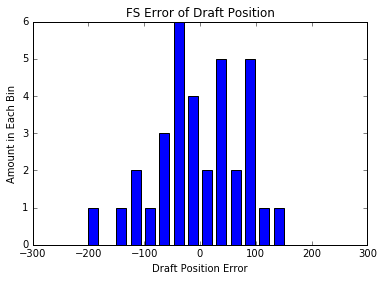

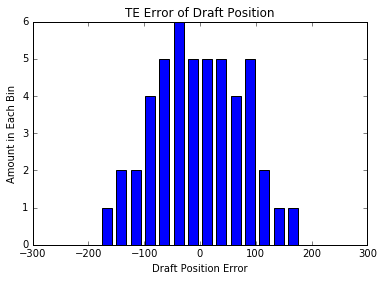

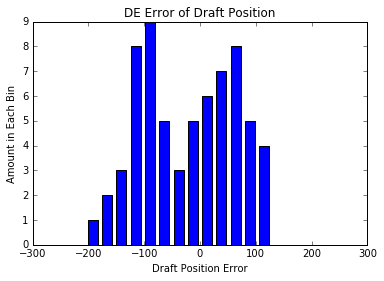

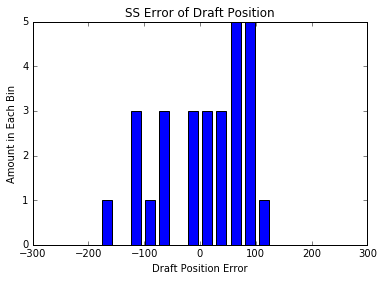

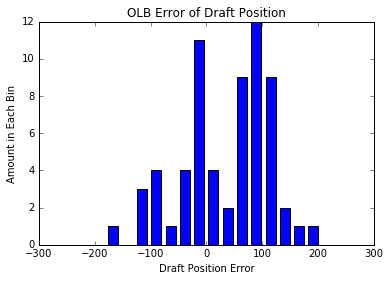

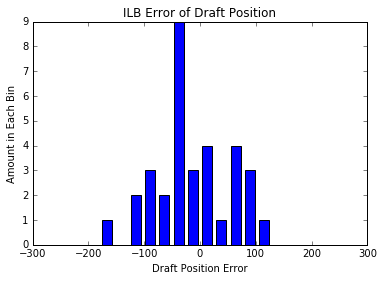

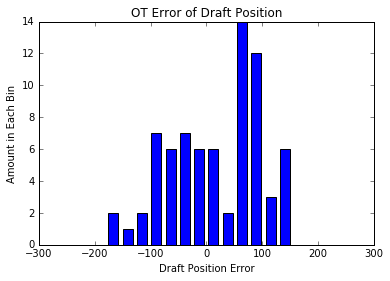

In [9]:
for i in range(len(D_errors)):
    hist, bins = np.histogram(D_errors[i], bins=20,range=(-256,256))
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.bar(center, hist, align='center', width=width)
    plt.title('{} Error of Draft Position'.format(poss[i]))
    plt.ylabel('Amount in Each Bin')
    plt.xlabel('Draft Position Error')
    plt.show()

**Part IV: Ordinary Least Squares Model For Games Started**

*Part IV.i: Creating the OLS model for Games Started*

We used our combine data as our Design Matrix and the Games Started as our observation vector. We split the data into training and testing, with our training data being 60% of our entire dataset. We also created an OLS for each position because we felt that this increased the fit of our model. We ran the model then on the test set for each position and obtain the errors for each position.

In [11]:
all_predictions_GS=[]
all_results_GS=[]
G_errors=[]
for pos in poss:
#     print('\n\n\n--------------' + pos + '---------------')
    P_pos = P2.loc[P2['POS'] == pos]
    
    if pos == 'QB':
        X_P_H = P_pos[uQB]
    else:
        X_P_H = P_pos[usable1]
    print('Complete dataset shape is {}'.format(X_P_H.shape))
    y_P_H = P_pos.GS;

    X_P_H, y_P_H = utils.shuffle(X_P_H, y_P_H, random_state=1)
    X_P_H_train, X_P_H_test, y_P_H_train, y_P_H_test = cross_validation.train_test_split(
        X_P_H, y_P_H, test_size=0.4, random_state=0)

    subX_train = X_P_H_train[X_P_H_train.columns[0]]
    subX_test = X_P_H_test[X_P_H_test.columns[0]]
    
    model = sm.OLS(y_P_H_train.astype(float), X_P_H_train.astype(float), missing='drop')
    results = model.fit()
    predictions = results.predict(X_P_H_test.astype(float))
    all_predictions_GS.append(predictions)
    all_results_GS.append([float(x) for x in list(y_P_H_test)])
    print(results.summary())

for i in range(len(all_predictions_GS)):
    pos_error= []
    for j in range(len(all_predictions_GS[i])):
        pos_error.append(all_predictions_GS[i][j] - all_results_GS[i][j])
    G_errors.append(pos_error)

    

Complete dataset shape is (156, 9)
                            OLS Regression Results                            
Dep. Variable:                     GS   R-squared:                       0.532
Model:                            OLS   Adj. R-squared:                  0.482
Method:                 Least Squares   F-statistic:                     10.60
Date:                Wed, 14 Dec 2016   Prob (F-statistic):           8.46e-11
Time:                        03:30:27   Log-Likelihood:                -269.12
No. Observations:                  93   AIC:                             556.2
Df Residuals:                      84   BIC:                             579.0
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
AP Poll P

In [12]:
for i in range(len(poss)):
    print(poss[i],' errors in terms predicted draft values and actual drafted values are', G_errors[i])

DT  errors in terms predicted draft values and actual drafted values are [-5.2918156802786465, 1.4941931634587462, -3.6681319708438451, -7.6479123891221201, -6.910734878327764, -8.3841031658948708, 1.344301893777069, -5.6991380213310308, 5.7258628365168036, 3.5721875901600555, -2.0224372070208831, -0.35836422203966833, -9.9881220155597994, -4.7273283907589354, -11.640732704564169, 2.1653549440133268, 6.6048405021348007, 2.6036379764896056, -12.120305439131052, -1.7263316149666488, 3.0844539754697697, -4.0943167671273031, -5.040087619973793, 3.1444665950268424, 2.6782563141606568, -0.44485731836828091, 3.8977307249952799, 1.2540390741895218, 2.4342332623085809, 3.8044308075843176, -0.62502232444103711, -0.56106093749288011, 1.6936986038580129, 6.8256810171407913, -6.095516878453938, -0.76621846170558161, -7.6437751070463777, 0.52029268912270599, 5.9637402268297421, -1.6655972002224946, 2.3172220090830145, 2.8680348624391456, 1.6123948697413337, 3.0021206676196011, 3.693934396359031, 2.4

*Part III.ii: Histogram of Errors*

We plotted the errors of draft position of the test set to actual results on a histogram with our range being -256 to 256. The further from 0 the value was meant the more we either overestimated or underestimated the draft position.

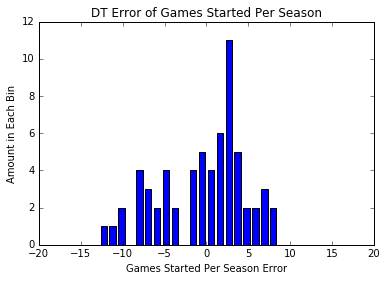

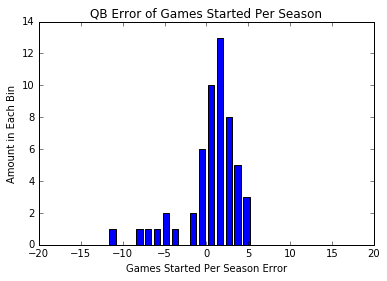

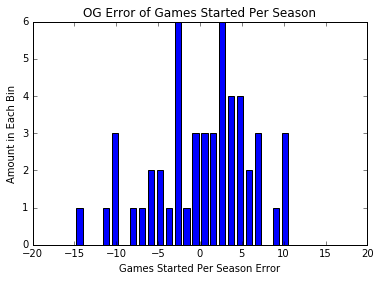

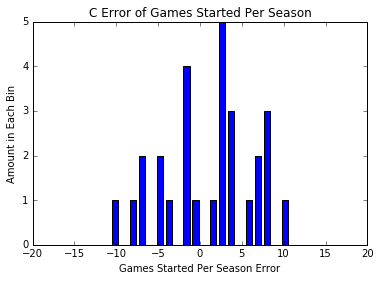

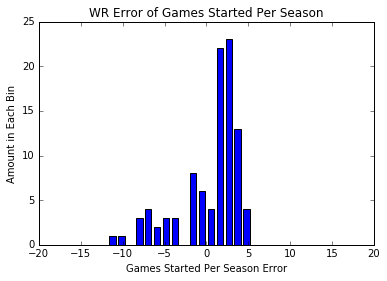

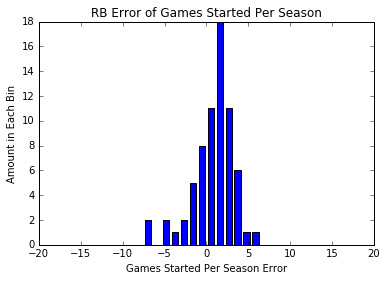

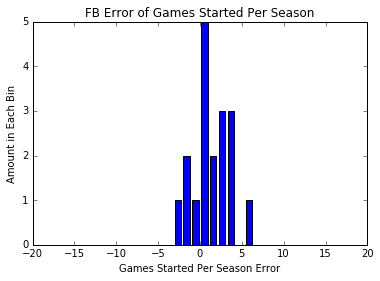

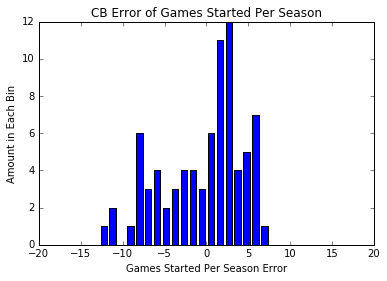

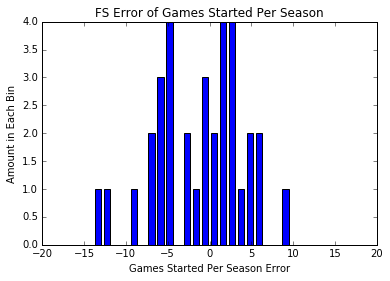

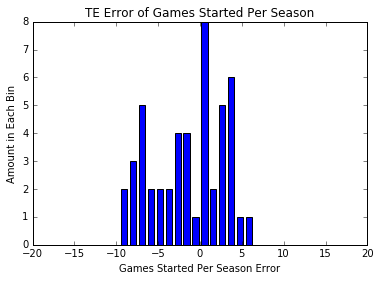

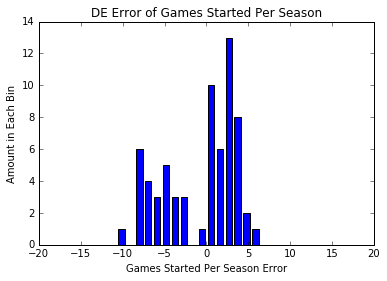

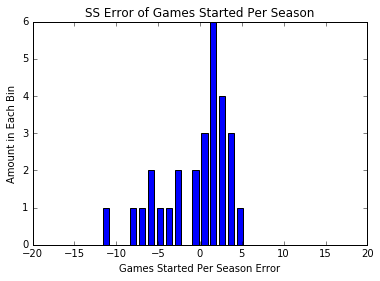

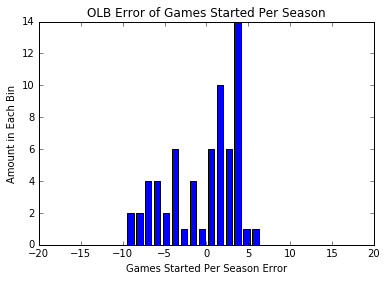

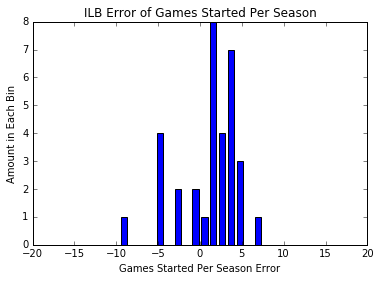

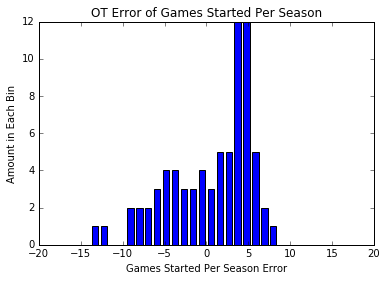

In [13]:
for i in range(len(G_errors)):
    hist, bins = np.histogram(G_errors[i], bins=30,range=(-16,16))
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.bar(center, hist, align='center', width=width)
    plt.title('{} Error of Games Started Per Season'.format(poss[i]))
    plt.ylabel('Amount in Each Bin')
    plt.xlabel('Games Started Per Season Error')
    plt.show()
    plt.show()